In [1]:
%matplotlib inline

In [91]:
import numpy as np
import pandas as pd
from sparsesvd import sparsesvd 
from scipy.sparse import csc_matrix
import seaborn as sns; sns.set()

In [9]:
def argminBIC(lambdas, w_inv_nonzero, cand_nonzero, index, X, sigma_sq, n, d, old, isV):
    """index for lowest BIC"""
    BICs = np.ones(lambdas.shape[0]-1)*np.Inf
    for i in range(BICs.shape[0]):
        temp_partial = update(cand_nonzero, lambdas[i])/w_inv_nonzero
        if(isV==1):
            temp = np.zeros((d,1))
            temp[index] = temp_partial
            pred = old@temp.T
        else:
            temp = np.zeros((n,1))
            temp[index] = temp_partial
            pred = temp@old.T
        BICs[i] = np.sum((X-pred)**2)/sigma_sq + np.sum(temp_partial!=0)*np.log(n*d)
    best = np.argmin(BICs)
    return best

In [4]:
def update(candidate, penalty):
    """update v or u for SSVD"""
    return np.sign(candidate)*(np.abs(candidate)>= penalty)*(np.abs(candidate) - penalty)

In [22]:
def SSVD_function(X, gamma1 = 2, gamma2 = 2, tol = 1e-4, max_iter = 100):
    """SSVD for 1 layer"""
    u, s, v = sparsesvd(csc_matrix(X), k=1)

    # initiations
    n = X.shape[0]
    d = X.shape[1]
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    u_delta = 1
    v_delta = 1
    niter = 0
    SST = np.sum(X**2)
    
    while((u_delta > tol) or (v_delta > tol)):
        niter += 1

        ## Update v
        Xu = X.T @ u
        w2_inv = np.abs(Xu)**gamma2
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-d)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        # prepare lambda and candicates
        Xu_w = Xu*w2_inv                                  # X.T @ u/w
        lambda2s = np.unique(np.append(np.abs(Xu_w), 0))
        lambda2s.sort()                                   # possible lambda2/2
        index = np.where(w2_inv>1e-8)
        w2_inv_nonzero = w2_inv[index]
        Xu_w_nonzero = Xu_w[index]

        # best lambda and new v
        best = argminBIC(lambda2s, w2_inv_nonzero, Xu_w_nonzero, index, X, sigma_sq, n, d, old=u, isV=1)
        lambda2 = lambda2s[best]
        v_new_partial = update(Xu_w_nonzero, lambda2)/w2_inv_nonzero
        v_new = np.zeros((d,1))
        v_new[index] = v_new_partial
        v_new = v_new/np.sqrt(np.sum(v_new**2))

        # update v
        v_delta = np.sqrt(np.sum((v-v_new)**2))
        v = v_new

        ## Update u
        Xv = X @ v
        w1_inv = np.abs(Xv)**gamma1
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-n)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        # prepare lambda and candicates
        Xv_w = Xv*w1_inv                                  # X.T @ u/w
        lambda1s = np.unique(np.append(np.abs(Xv_w), 0))
        lambda1s.sort()                                   # possible lambda2/2
        index = np.where(w1_inv>1e-8)
        w1_inv_nonzero = w1_inv[index]
        Xv_w_nonzero = Xv_w[index]

        # best lambda and new u
        best = argminBIC(lambda1s, w1_inv_nonzero, Xv_w_nonzero, index, X, sigma_sq, n, d, old=v, isV=0)
        lambda1 = lambda1s[best]
        u_new_partial = update(Xv_w_nonzero, lambda1)/w1_inv_nonzero
        u_new = np.zeros((n,1))
        u_new[index] = u_new_partial
        u_new = u_new/np.sqrt(np.sum(u_new**2))

        # update u
        u_delta = np.sqrt(np.sum((u-u_new)**2))
        u = u_new
        
        # check iteration
        if(niter > max_iter):
            print("Fail to converge")
        
    return(u, s, v, niter)

In [117]:
def SSVD_primary(X, gamma1 = 2, gamma2 = 2, tol = 1e-4, max_iter = 100):
    """SSVD for 1 layer"""
    u, s, v = sparsesvd(csc_matrix(X), k=1)
    
    # initializations
    n = X.shape[0]
    d = X.shape[1]
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    u_delta = 1
    v_delta = 1
    niter = 0
    SST = np.sum(X**2)
    
    while((u_delta > tol) or (v_delta > tol)):
        niter += 1

        # update v
        Xu = X.T @ u
        w2_inv = np.abs(Xu)**gamma2
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-d)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        lambda2s = np.unique(np.append(np.abs(Xu*w2_inv), 0))
        lambda2s.sort()                                   # possible lambda2/2

        # best BIC
        BICs = np.ones(lambda2s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            v_temp = np.sign(Xu)*(np.abs(Xu) >= lambda2s[i] / w2_inv)*(np.abs(Xu) - lambda2s[i] / w2_inv)
            BICs[i] = np.sum((X-u@v_temp.T)**2)/sigma_sq/(n*d) + np.sum(v_temp!=0)*np.log(n*d)/(n*d)
        best = np.argmin(BICs)

        lambda2 = lambda2s[best]
        v_new = np.sign(Xu)*(np.abs(Xu) >= lambda2 / w2_inv)*(np.abs(Xu) - lambda2 / w2_inv)
        v_new = v_new/np.sqrt(np.sum(v_new**2))

        v_delta = np.sqrt(np.sum((v-v_new)**2))
        v = v_new


        # update u
        Xv = X @ v
        w1_inv = np.abs(Xv)**gamma1
        sigma_sq = np.abs(SST - sum(Xv**2))/(n*d-n) 

        lambda1s = np.unique(np.append(np.abs(Xv*w1_inv), 0))
        lambda1s.sort()                                   # possible lambda1/2

        # best BIC
        BICs = np.ones(lambda1s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            u_temp = np.sign(Xv)*(np.abs(Xv) >= lambda1s[i] / w1_inv)*(np.abs(Xv) - lambda1s[i] / w1_inv)
            BICs[i] = np.sum((X-u_temp@v.T)**2)/sigma_sq/(n*d) + np.sum(u_temp!=0)*np.log(n*d)/(n*d)
        best = np.argmin(BICs)

        lambda1 = lambda1s[best]
        u_new = np.sign(Xv)*(np.abs(Xv) >= lambda1 / w1_inv)*(np.abs(Xv) - lambda1 / w1_inv)
        u_new = u_new/np.sqrt(np.sum(u_new**2))

        u_delta = np.sqrt(np.sum((u-u_new)**2))
        u = u_new

        # check iterations
        if niter > max_iter:
            print("Fail to converge! Increase the max_iter!")
            break
    return(np.ravel(u), s, np.ravel(v), niter)

In [95]:
def SSVD_second(X, gamma1 = 2, gamma2 = 2, tol = 1e-4, max_iter = 100):
    """SSVD for 1 layer"""
    u, s, v = sparsesvd(csc_matrix(X), k=1)

    # initiations
    n = X.shape[0]
    d = X.shape[1]
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    u_delta = 1
    v_delta = 1
    niter = 0
    SST = np.sum(X**2)
    
    while((u_delta > tol) or (v_delta > tol)):
        niter += 1

        ## Update v
        Xu = X.T @ u
        w2_inv = np.abs(Xu)**gamma2
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-d)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        # prepare lambda and candicates
        Xu_w = Xu*w2_inv                                  # X.T @ u/w
        lambda2s = np.unique(np.append(np.abs(Xu_w), 0))
        lambda2s.sort()                                   # possible lambda2/2
        index = np.where(w2_inv>1e-8)
        w2_inv_nonzero = w2_inv[index]
        Xu_w_nonzero = Xu_w[index]

        # best lambda and new v
        BICs = np.ones(lambda2s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            temp_partial = np.sign(Xu_w_nonzero)*(np.abs(Xu_w_nonzero)>=lambda2s[i])*(np.abs(Xu_w_nonzero)-lambda2s[i])
            temp = np.zeros((d,1))
            temp[index] = temp_partial/w2_inv_nonzero
            BICs[i] = np.sum((X-u@temp.T)**2)/sigma_sq + np.sum(temp_partial!=0)*np.log(n*d)
        best = np.argmin(BICs)
        lambda2 = lambda2s[best]
        v_new_partial = np.sign(Xu_w_nonzero)*(np.abs(Xu_w_nonzero)>=lambda2)*(np.abs(Xu_w_nonzero)-lambda2)/w2_inv_nonzero
        v_new = np.zeros((d,1))
        v_new[index] = v_new_partial
        v_new = v_new/np.sqrt(np.sum(v_new**2))

        # update v
        v_delta = np.sqrt(np.sum((v-v_new)**2))
        v = v_new

        ## Update u
        Xv = X @ v
        w1_inv = np.abs(Xv)**gamma1
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-n)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        # prepare lambda and candicates
        Xv_w = Xv*w1_inv                                  # X.T @ u/w
        lambda1s = np.unique(np.append(np.abs(Xv_w), 0))
        lambda1s.sort()                                   # possible lambda2/2
        index = np.where(w1_inv>1e-8)
        w1_inv_nonzero = w1_inv[index]
        Xv_w_nonzero = Xv_w[index]

        # best lambda and new u
        BICs = np.ones(lambda1s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            temp_partial = np.sign(Xv_w_nonzero)*(np.abs(Xv_w_nonzero)>=lambda1s[i])*(np.abs(Xv_w_nonzero)-lambda1s[i])
            temp = np.zeros((n,1))
            temp[index] = temp_partial/w1_inv_nonzero
            BICs[i] = np.sum((X-temp@v.T)**2)/sigma_sq + np.sum(temp_partial!=0)*np.log(n*d)
        best = np.argmin(BICs)
        lambda1 = lambda1s[best]
        u_new_partial = np.sign(Xv_w_nonzero)*(np.abs(Xv_w_nonzero)>=lambda1)*(np.abs(Xv_w_nonzero)-lambda1)/w1_inv_nonzero
        u_new = np.zeros((n,1))
        u_new[index] = u_new_partial
        u_new = u_new/np.sqrt(np.sum(u_new**2))

        # update u
        u_delta = np.sqrt(np.sum((u-u_new)**2))
        u = u_new
        
        # check iteration
        if(niter > max_iter):
            print("Fail to converge")
        
    return(np.ravel(u), s, np.ravel(v), niter)

In [ ]:
@jit(float64[:](float64[:]), nopython=True)
def SSVD_second(X, gamma1 = 2, gamma2 = 2, tol = 1e-4, max_iter = 100):
    """SSVD for 1 layer"""
    u, s, v = sparsesvd(csc_matrix(X), k=1)

    # initiations
    n = X.shape[0]
    d = X.shape[1]
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    u_delta = 1
    v_delta = 1
    niter = 0
    SST = np.sum(X**2)
    
    while((u_delta > tol) or (v_delta > tol)):
        niter += 1

        ## Update v
        Xu = X.T @ u
        w2_inv = np.abs(Xu)**gamma2
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-d)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        # prepare lambda and candicates
        Xu_w = Xu*w2_inv                                  # X.T @ u/w
        lambda2s = np.unique(np.append(np.abs(Xu_w), 0))
        lambda2s.sort()                                   # possible lambda2/2
        index = np.where(w2_inv>1e-8)
        w2_inv_nonzero = w2_inv[index]
        Xu_w_nonzero = Xu_w[index]

        # best lambda and new v
        BICs = np.ones(lambda2s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            temp_partial = np.sign(Xu_w_nonzero)*(np.abs(Xu_w_nonzero)>=lambda2s[i])*(np.abs(Xu_w_nonzero)-lambda2s[i])
            temp = np.zeros((d,1))
            temp[index] = temp_partial/w2_inv_nonzero
            BICs[i] = np.sum((X-u@temp.T)**2)/sigma_sq + np.sum(temp_partial!=0)*np.log(n*d)
        best = np.argmin(BICs)
        lambda2 = lambda2s[best]
        v_new_partial = np.sign(Xu_w_nonzero)*(np.abs(Xu_w_nonzero)>=lambda2)*(np.abs(Xu_w_nonzero)-lambda2)/w2_inv_nonzero
        v_new = np.zeros((d,1))
        v_new[index] = v_new_partial
        v_new = v_new/np.sqrt(np.sum(v_new**2))

        # update v
        v_delta = np.sqrt(np.sum((v-v_new)**2))
        v = v_new

        ## Update u
        Xv = X @ v
        w1_inv = np.abs(Xv)**gamma1
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-n)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        # prepare lambda and candicates
        Xv_w = Xv*w1_inv                                  # X.T @ u/w
        lambda1s = np.unique(np.append(np.abs(Xv_w), 0))
        lambda1s.sort()                                   # possible lambda2/2
        index = np.where(w1_inv>1e-8)
        w1_inv_nonzero = w1_inv[index]
        Xv_w_nonzero = Xv_w[index]

        # best lambda and new u
        BICs = np.ones(lambda1s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            temp_partial = np.sign(Xv_w_nonzero)*(np.abs(Xv_w_nonzero)>=lambda1s[i])*(np.abs(Xv_w_nonzero)-lambda1s[i])
            temp = np.zeros((n,1))
            temp[index] = temp_partial/w1_inv_nonzero
            BICs[i] = np.sum((X-temp@v.T)**2)/sigma_sq + np.sum(temp_partial!=0)*np.log(n*d)
        best = np.argmin(BICs)
        lambda1 = lambda1s[best]
        u_new_partial = np.sign(Xv_w_nonzero)*(np.abs(Xv_w_nonzero)>=lambda1)*(np.abs(Xv_w_nonzero)-lambda1)/w1_inv_nonzero
        u_new = np.zeros((n,1))
        u_new[index] = u_new_partial
        u_new = u_new/np.sqrt(np.sum(u_new**2))

        # update u
        u_delta = np.sqrt(np.sum((u-u_new)**2))
        u = u_new
        
        # check iteration
        if(niter > max_iter):
            print("Fail to converge")
        
    return(np.ravel(u), s, np.ravel(v), niter)

## Paper Data

In [ ]:
data = pd.read_csv('data/data.txt', sep=' ', header = None)
X = np.array(data.T)

In [120]:
%%time
u, s, v, niter = SSVD_primary(X)

CPU times: user 100 ms, sys: 4 ms, total: 104 ms
Wall time: 99.3 ms


In [ ]:
%%time
u, s, v, niter = SSVD_second(X)

In [ ]:
n = X.shape[0]
d = X.shape[1]
first = s*u.reshape((n, 1))@v.reshape((1, d))

In [ ]:
group1 = range(20)
group2 = range(20, 33)
group3 = range(33, 50)
group4 = range(50, 56)

row_idx = np.concatenate((np.argsort(u[group1]), np.argsort(u[group2])+20, np.argsort(u[group3])+33, np.argsort(u[group4])+50))
col_nonzero = np.argsort(np.abs(v))[8000:]
v_nonzero = v[col_nonzero]
first_nonzero = first[:,col_nonzero]
col_idx = np.argsort(v_nonzero)

ax = sns.heatmap(first_nonzero[np.ix_(row_idx, col_idx)], vmin=-1, vmax=1, cmap = 'bwr')

## Simulation

In [96]:
u_tilde = np.r_[np.arange(3,11)[::-1], 2*np.ones(17), np.zeros(75)].reshape((-1,1))
u = u_tilde/np.linalg.norm(u_tilde)
v_tilde = np.r_[np.array([10,-10,8,-8,5,-5]),3*np.ones(5),-3*np.ones(5),np.zeros(34)].reshape((-1,1))
v = v_tilde/np.linalg.norm(v_tilde)
s = 50

X_star = s*u@v.T
n, d = X_star.shape
X_sim = X_star + np.random.randn(n,d)

In [118]:
%%time
u, s, v, niter = SSVD_primary(X_sim)

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 43.6 ms


In [119]:
%%time
u, s, v, niter = SSVD_second(X_sim)

CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 50.4 ms


In [99]:
n = X.shape[0]
d = X.shape[1]
first = s*u.reshape((n, 1))@v.reshape((1, d))

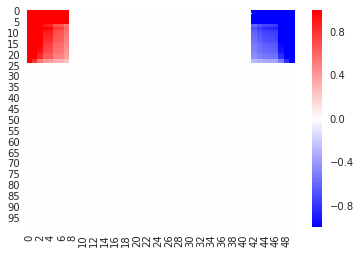

In [116]:
group1 = range(8)
group2 = range(8, 25)
group3 = range(25, 100)

row_idx = np.concatenate((np.argsort(u[group1]), np.argsort(u[group2])+8, np.argsort(u[group3])+25))
col_nonzero = np.argsort(np.abs(v))
v_nonzero = v[col_nonzero]
first_nonzero = first[:,col_nonzero]
col_idx = np.argsort(v_nonzero)

ax = sns.heatmap(first_nonzero[np.ix_(row_idx, col_idx)], vmin=-1, vmax=1, cmap = 'bwr')